# Fraser Canyon DC Resistivity Inversion
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
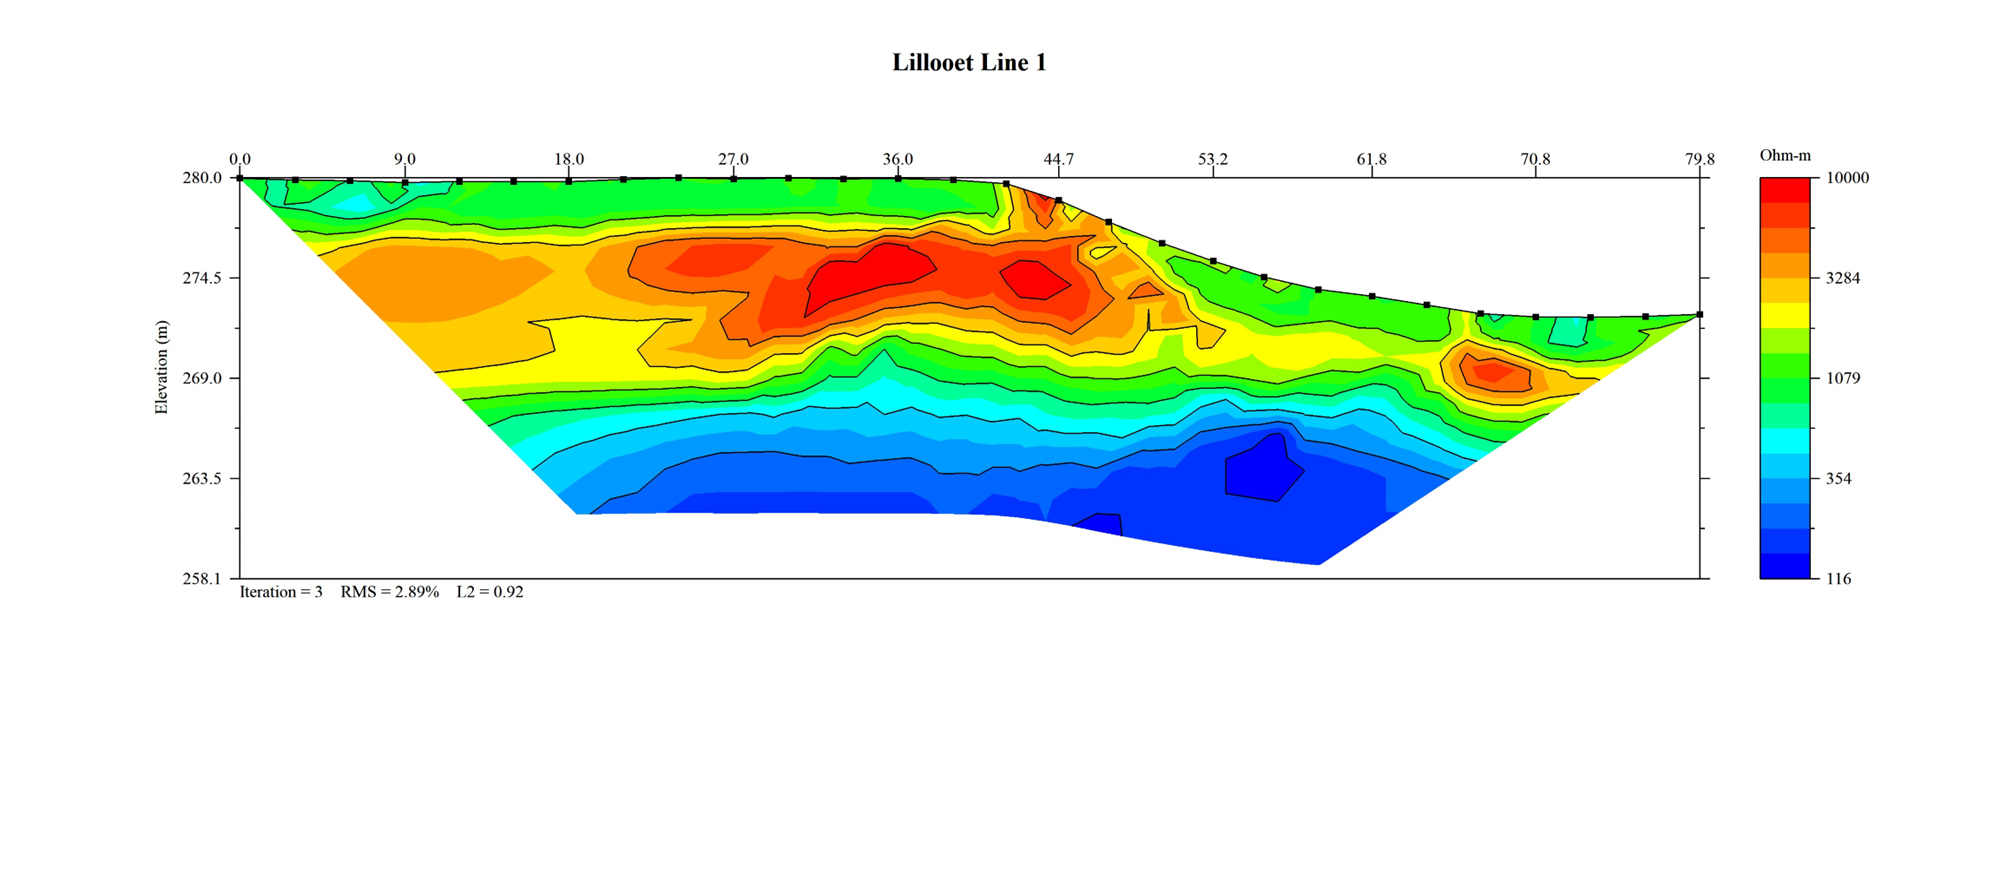

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity tutorial notebook (https://simpeg.xyz/user-tutorials/fwd-dcr-2d). 

## Import packages for forward modelling

In [1]:
# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import pandas as pd

# SimPEG functionality
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    write_dcip2d_ubc,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations,
    geometric_factor
)
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc,active_from_xyz

# Functions specific to this project
from project_functions import (
    create_topography_from_terrain_file,
    plot_topography_from_dataframe,
    extract_survey_and_data_from_stg,
    plot_survey,
    create_mesh_from_survey,
    plot_mesh_and_survey,
    plot_model_on_survey_and_mesh,
    plot_normalized_volts_and_apparent_resistivity,
    create_data_object,
    save_model_to_txt,
    load_model_from_txt,
    plot_initial_and_recovered_models,
    plot_histogram_of_relative_misfits)

mpl.rcParams.update({"font.size": 14})  # default font size
# sphinx_gallery_thumbnail_number = 4

## Parameters

In [2]:
# Field data files
TERRAIN_FILE_COLUMN_NAMES = ['x','z']
TERRAIN_FILE_PATH = './fieldData/Terrain_Line1_3m_Aug26_2024.trn'
STG_FILEPATH = './fieldData/3m_Texas_Creek_line1_2024.stg'

# Mesh parameters
BASE_CELL_SIZE = 0.75 # meters
PADDING_CONFIGURATION = [15,15,2,2]

# Define resistivity values of different materials
air_logresistivity = np.log(1e+15)
mud_logresistivity = np.log(1e+2)
sand_logresistivity = np.log(1e+3)
gravel_logresistivity = np.log(1e+4)
air_resistivity = 1e+8

# Assumed noise level of field data
FIELD_NOISE = 0.15

# INVERSION
# Define the regularization parameters. Set to 'None' to use SimPEG's calculated default value
ALPHA_S = 1e-6 # Smallness
ALPHA_X = 1e-1 # Horizontal smoothness
ALPHA_Z = 1e-6 # Vertical smoothness
REFERENCE_MODEL = None #starting_logresistivity_model # The smallness is computed as the difference wrt this model.

# Beta reduction parameters
COOLING_FACTOR = 3 # factor by which beta is decreased
COOLING_RATE = 2 # number of iterations for each beta (set to 3 for very non-linear problems, 1 for linear problems)

# Stopping criterion
CHI_FACTOR = 1 # factor multiplied to size of data (or phi_d_star, if given) to get stopping misfit

## Define topography 
Use create_topography_from_terrain_file function.

In [3]:
topography_2d = create_topography_from_terrain_file(terrain_file_path=TERRAIN_FILE_PATH,
                                                    terrain_file_column_names=TERRAIN_FILE_COLUMN_NAMES)

# plot_topography_from_dataframe(topography_2d)

## Generate survey object
Use the topography data and the raw .stg data file.

In [4]:
survey, field_VI, field_Ohmm, field_error, sorting_indices = extract_survey_and_data_from_stg(
    topography_2d=topography_2d,
    stg_filepath=STG_FILEPATH,
    datatype='volt'
    )

# # Check survey
# attributes = vars(survey)
# for att, value in attributes.items():
#     print(f"{att}: {value}")

# plot_survey(survey)

Note: If you see 'UserWarning: Ordering of ABMN locations changed when generating survey,' you may disregard it 
because the extract_survey_and_data_from_stg function sorts the data for you. To compare the survey and sorted data 
with the unsorted data, this function also returns the sorting_indices array that was used to sort the raw data. 



c:\GitSpaces\eosc-556b-project\project_functions.py:165: UserWarning: Ordering of ABMN locations changed when generating survey. Associated data vectors will need sorting. Set output_sorting to True for sorting indices.
  survey, sorting_indices = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,


## Create Mesh object
- Use the create_mesh_from_survey function.
- Make adjustments to the survey based on the mesh.
- Then plot the survey on the mesh.

In [5]:
# Create mesh
mesh, active_cells = create_mesh_from_survey(survey=survey, base_cell_size=BASE_CELL_SIZE,
                                             padding_configuration=PADDING_CONFIGURATION)

# Define number of active cells, which is needed for the model generation and mapping.
n_active = np.sum(active_cells)

# Drape electrodes on topography to ensure none of them are "floating" in the air
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")
# Geometric factor is needed to convert from measured normalized voltages to apparent resistivities
survey.set_geometric_factor(space_type='half-space')

# # Plot the modified survey on the mesh
# plot_mesh_and_survey(mesh=mesh, survey=survey)

Base cell size: 0.75 m
padding_cells_by_level parameter: [15, 15, 2, 2]
# of cells: 4505
# of nodes: 4734
Max cell volume: 576.0 sq.m.


## Create starting/background model

In [6]:
# # Define background resistivity model
# logresistivity_model = sand_logresistivity *np.ones(n_active)
# starting_logresistivity_model = sand_logresistivity *np.ones(n_active)

## Create Map objects
One for the inversion (i.e., resistivity_map) where the inactive cells are given the res. value of air to keep the inversion stable.

One for figures (i.e., plotting_map) where the inactive cells are given nan values, so that they simply aren't plotted.

In [7]:
# Resistivity map. Model parameters are resistivities for all active cells.
# Assign value of air to inactive cells
logresistivity_map = maps.InjectActiveCells(mesh=mesh,
                                            active_cells=active_cells,
                                            value_inactive=air_resistivity
                                            ) * maps.ExpMap(nP=n_active)

# Generate a mapping to ignore inactive cells in plot. Whenever you want to plot the model, you need to multiply
# the resistivity values by this plotting map
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

## Create Simulation object from the Mesh, the Survey, and the resistivity Map

In [8]:
# First define the DC simulation given the survey setup, the mesh, and the active parts of the mesh
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=logresistivity_map
)

## Create Field Data object

array([<Axes: title={'center': 'Field Data Normalized Voltages'}, ylabel='Pseudo-elevation [m]'>,
       <Axes: title={'center': 'Field Data Apparent Resistivity'}, xlabel='x [m]', ylabel='Pseudo-elevation [m]'>],
      dtype=object)

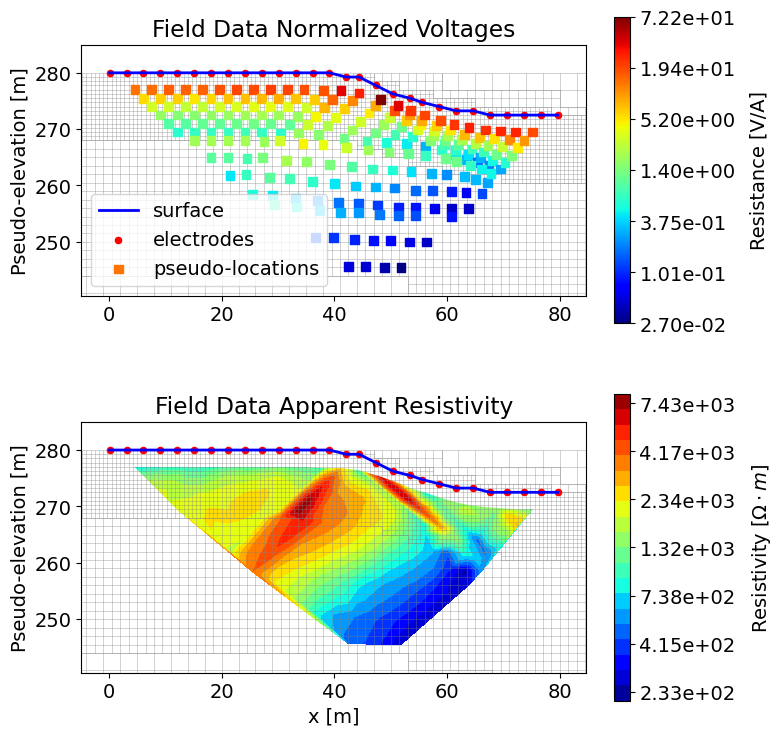

In [37]:
# Plot field data
plot_normalized_volts_and_apparent_resistivity(data=field_data.dobs, survey=survey, mesh=mesh, title='Field Data')

In [9]:
# Create data object
field_data, errors = create_data_object(data_values=field_VI, survey=survey, add_noise=False,
                                        uncertainties=np.ones_like(field_error)*FIELD_NOISE,
                                        export=True, filename='field_data')

# Print attributes
attributes = vars(field_data)
for name, value in attributes.items():
    print(f"{name}: {value}")

The Data object was saved to ./outputs/Data_objects/field_data.obs
_survey: Survey(#sources: 52; #data: 215)
_dobs: [1.3619e+01 5.6481e+00 3.1473e+00 1.7792e+00 9.5521e-01 6.4317e-01
 1.4129e+01 6.0858e+00 3.0625e+00 1.5314e+00 9.8142e-01 7.0651e-01
 1.6094e+01 6.1753e+00 2.7164e+00 1.6069e+00 1.0994e+00 7.2900e-01
 1.5828e+01 5.2197e+00 2.6839e+00 1.6975e+00 1.0737e+00 7.2129e-01
 1.5920e+01 5.9280e+00 3.1945e+00 1.8299e+00 1.1845e+00 7.7828e-01
 1.8011e+01 6.9434e+00 3.3910e+00 2.0183e+00 1.2578e+00 7.1720e-01
 1.9277e+01 7.0046e+00 3.6425e+00 2.1004e+00 1.1361e+00 6.5934e-01
 1.8628e+01 7.5439e+00 3.8592e+00 1.9360e+00 1.0708e+00 1.8378e+00
 2.0639e+01 8.1554e+00 3.5890e+00 1.8424e+00 2.9667e+00 1.5327e+00
 2.0348e+01 6.8030e+00 3.0833e+00 4.4850e+00 2.2381e+00 1.2403e+00
 1.8595e+01 6.4176e+00 7.7926e+00 3.6523e+00 1.9121e+00 8.2755e-01
 1.7515e+01 1.5031e+01 6.2774e+00 3.0662e+00 1.2755e+00 5.8094e-01
 3.6038e+01 1.1364e+01 4.8251e+00 1.8702e+00 8.0232e-01 4.5528e-01
 2.7138e+01 8

# DC Resistivity 2.5D least-squares inversion 

## Define the DC Inverse Problem
The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [10]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=field_data, simulation=simulation_res)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=REFERENCE_MODEL,
    reference_model_in_smooth=True, # if True, the smoothness is applied to the difference wrt the ref. model
    alpha_s=ALPHA_S,
    alpha_x=ALPHA_X,
    alpha_z=ALPHA_Z
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [11]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=COOLING_FACTOR, coolingRate=COOLING_RATE)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# # Setting a stopping criteria for the inversion.
# CHI_FACTOR = 1 # factor multiplied to size of data (or phi_d_star, if given) to get target misfit
# TARGET_MISFIT = int(np.ceil(survey.nD/CHI_FACTOR))
target_misfit = directives.TargetMisfit(chifact=CHI_FACTOR)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Create and run the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [12]:
# Create starting model
average_field_data_value = np.log(np.mean(field_Ohmm))
starting_model = np.ones(n_active)*average_field_data_value
starting_model

array([7.4859904, 7.4859904, 7.4859904, ..., 7.4859904, 7.4859904,
       7.4859904], shape=(4287,))

In [13]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
# startingmodel= starting_logresistivity_model
recovered_resistivity_model = dc_inversion.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.90e+03  2.27e+04  0.00e+00  2.27e+04    3.01e+03      0              
   1  1.90e+03  4.29e+03  2.02e-01  4.68e+03    1.55e+03      0              
   2  6.33e+02  2.21e+03  2.09e-01  2.34e+03    9.44e+02      0   Skip BFGS  
   3  6.33e+02  9.25e+02  6.07e-01  1.31e+03    7.67e+02      0              
   4  2.11e+02  8.97e+02  5.67e-01  1.02e+03    7.20e+02      0              
   5  2.11e+02  4.89e+02  1.18e+00  7.37e+02    5.53e+02      0              
   6  7.04e+01  4.26e+02  1.10e+00  5.03e+02    3.50e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.2715e+03
1 : |xc-x_last| = 2.0585e+01 <= tolX*(1+|x0|) = 4.9115e+01
0 : |p

### Plot recovered model

In [ ]:
# First, some things to print
phi_d = inv_prob.phi_d

dpred = inv_prob.dpred
dobs = field_data.dobs
std = field_data.standard_deviation

residual = dpred - dobs
relative_misfits = (residual/np.abs(dobs)) 
standardized_misfits = (residual/std)
rms = np.sqrt(np.sum(relative_misfits**2)/relative_misfits.size)*100
print(f'RMS = {rms:.{1}f}%')

RMS = 13.2%


<Axes: title={'center': 'Model recovered from Field Data (RMS = 13.2%)'}, xlabel='x [m]', ylabel='elevation [m]'>

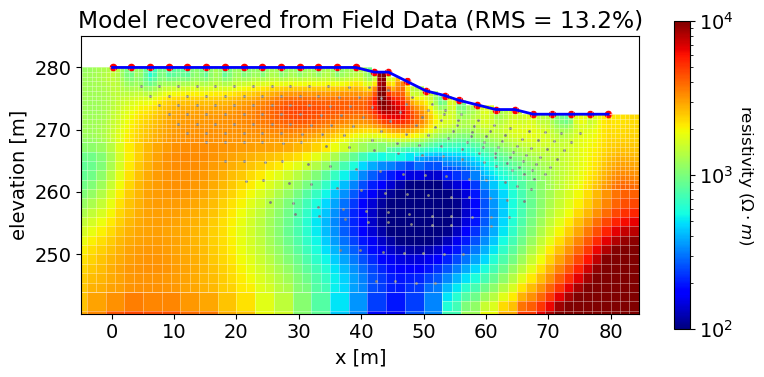

In [42]:
plot_model_on_survey_and_mesh(mesh=mesh, logresistivity_model=recovered_resistivity_model, plotting_map=plotting_map,
                              survey=survey, title=f"Model recovered from Field Data (RMS = {rms:.{1}f}%)",
                              model_min=1e+2, model_max=1e+4)

<Axes: title={'center': 'RMS = 13.2%'}, xlabel='Relative misfit', ylabel='Percentage of data points'>

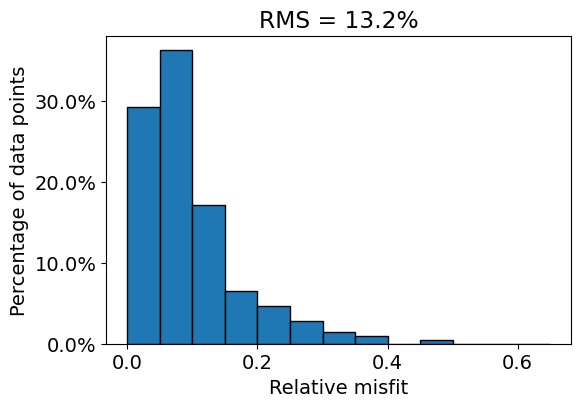

In [43]:
plot_histogram_of_relative_misfits(relative_misfits, bin_width=0.05)

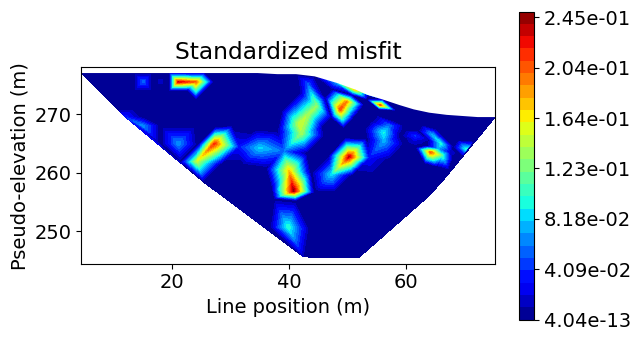

In [58]:
# Plot the standardized misfit
# I.e., the misfit expressed in units of the data's standard deviation (or estimated uncertainty).
fig, ax = plt.subplots(1,1, figsize=(6,4))

plot_pseudosection(data=field_data, dobs=standardized_misfits, plot_type="contourf", ax=ax, mask_topography=True,
                   scale='linear', contourf_opts={"levels": 25, "cmap": mpl.cm.jet})
# mesh.plot_grid(ax=ax, linewidth = 0.5, alpha=0.5, color='grey', zorder=1)
# ax.grid(False)

ax.set_title("Standardized misfit")
# Set vertical exaggeration
ax.set_aspect(1, adjustable='box')

# # Plot
# fig = plt.figure(figsize=(9, 13))
# data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
# plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
# plot_units = ["V/A", "V/A", ""]
# scale = ["log", "log", "linear"]

# ax1 = 3 * [None]
# cax1 = 3 * [None]
# cbar = 3 * [None]
# cplot = 3 * [None]

# for ii in range(0, 3):
#     ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
#     cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
#     cplot[ii] = plot_pseudosection(
#         survey,
#         data_array[ii],
#         "contourf",
#         ax=ax1[ii],
#         cax=cax1[ii],
#         scale=scale[ii],
#         cbar_label=plot_units[ii],
#         mask_topography=True,
#         contourf_opts={"levels": 25, "cmap": mpl.cm.viridis},
#     )
#     ax1[ii].set_title(plot_title[ii])

# plt.show()

In [19]:
# # RMS after noisy data removal. Uncomment before re-running.
# rms_cleaned = np.sqrt(np.sum(relative_misfits[~noisy_points_indices]**2)/relative_misfits[~noisy_points_indices].size)*100
# print(f'RMS = {rms_cleaned:.{1}f}%')

In [ ]:
# Find the noisy points.
noisy_points_indices = np.abs(relative_misfits) > 0.04
print(np.sum(noisy_points_indices))
# noisy_points_indices

171


In [ ]:
# Make the assumed error for the noisy points really high.
field_data.noise_floor[noisy_points_indices] = 10e10 * field_data.dobs[noisy_points_indices]
# field_data.standard_deviation

# Legacy stuff

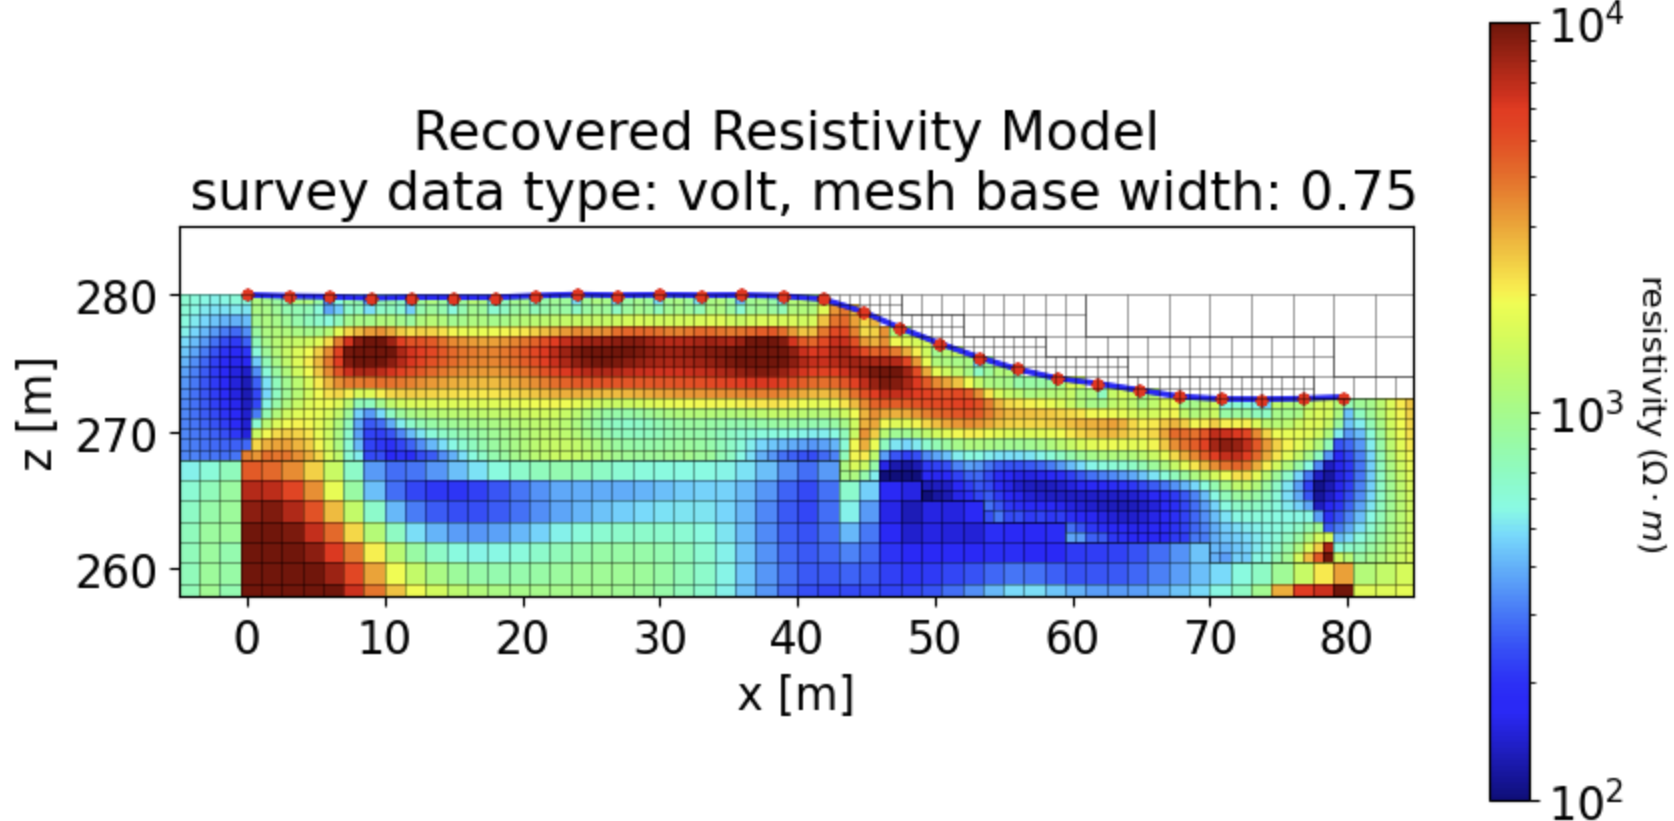
Field data:

With noise

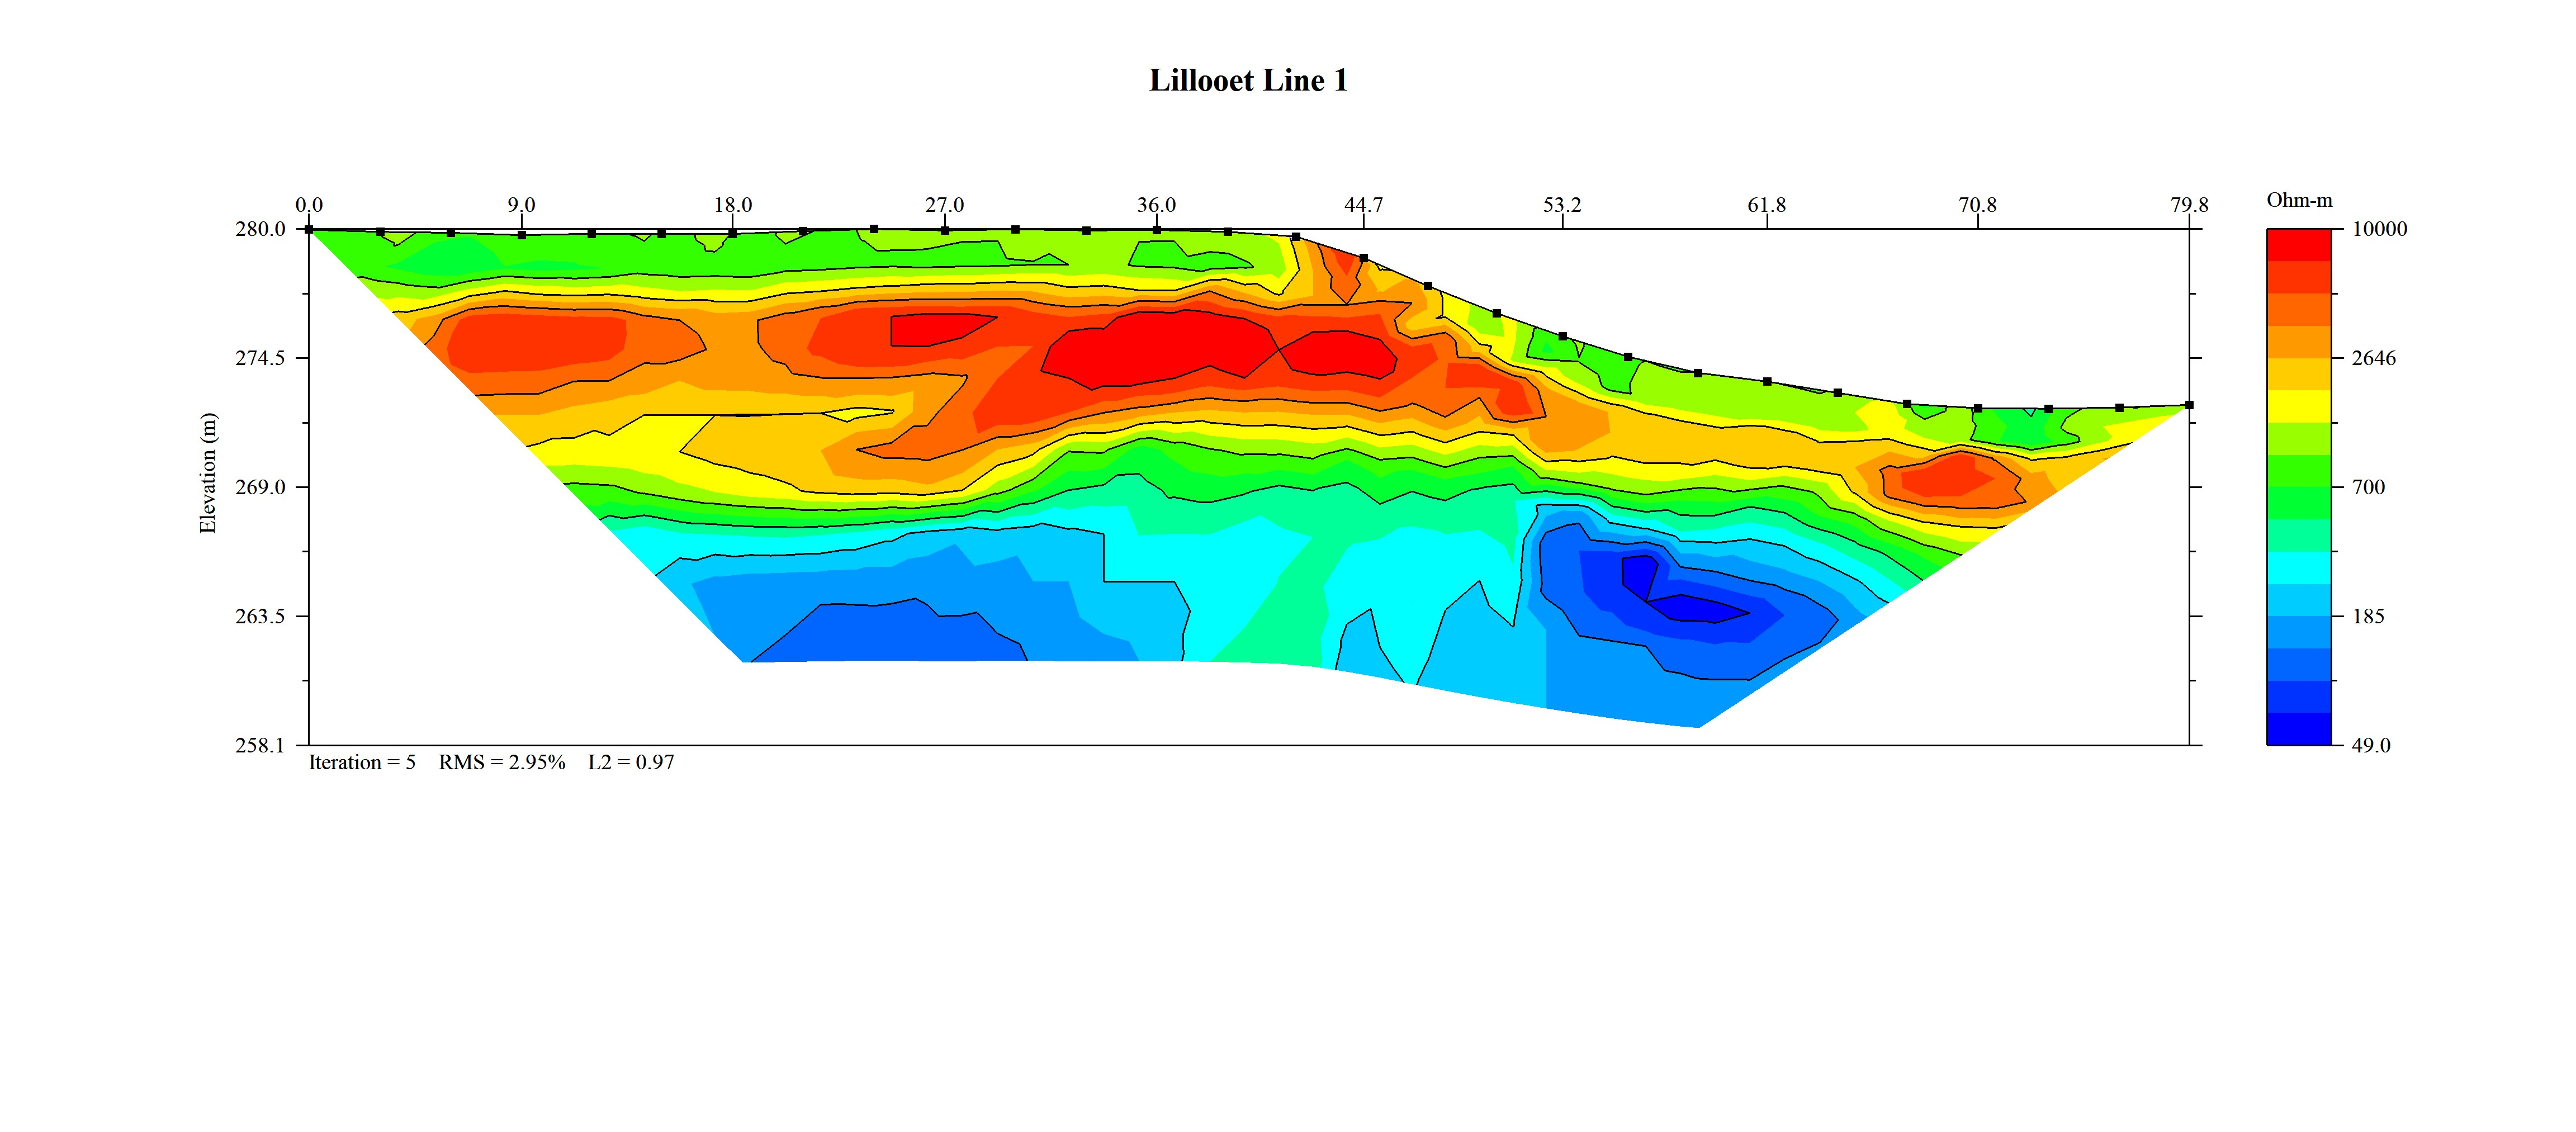

Noisy data points filtered out

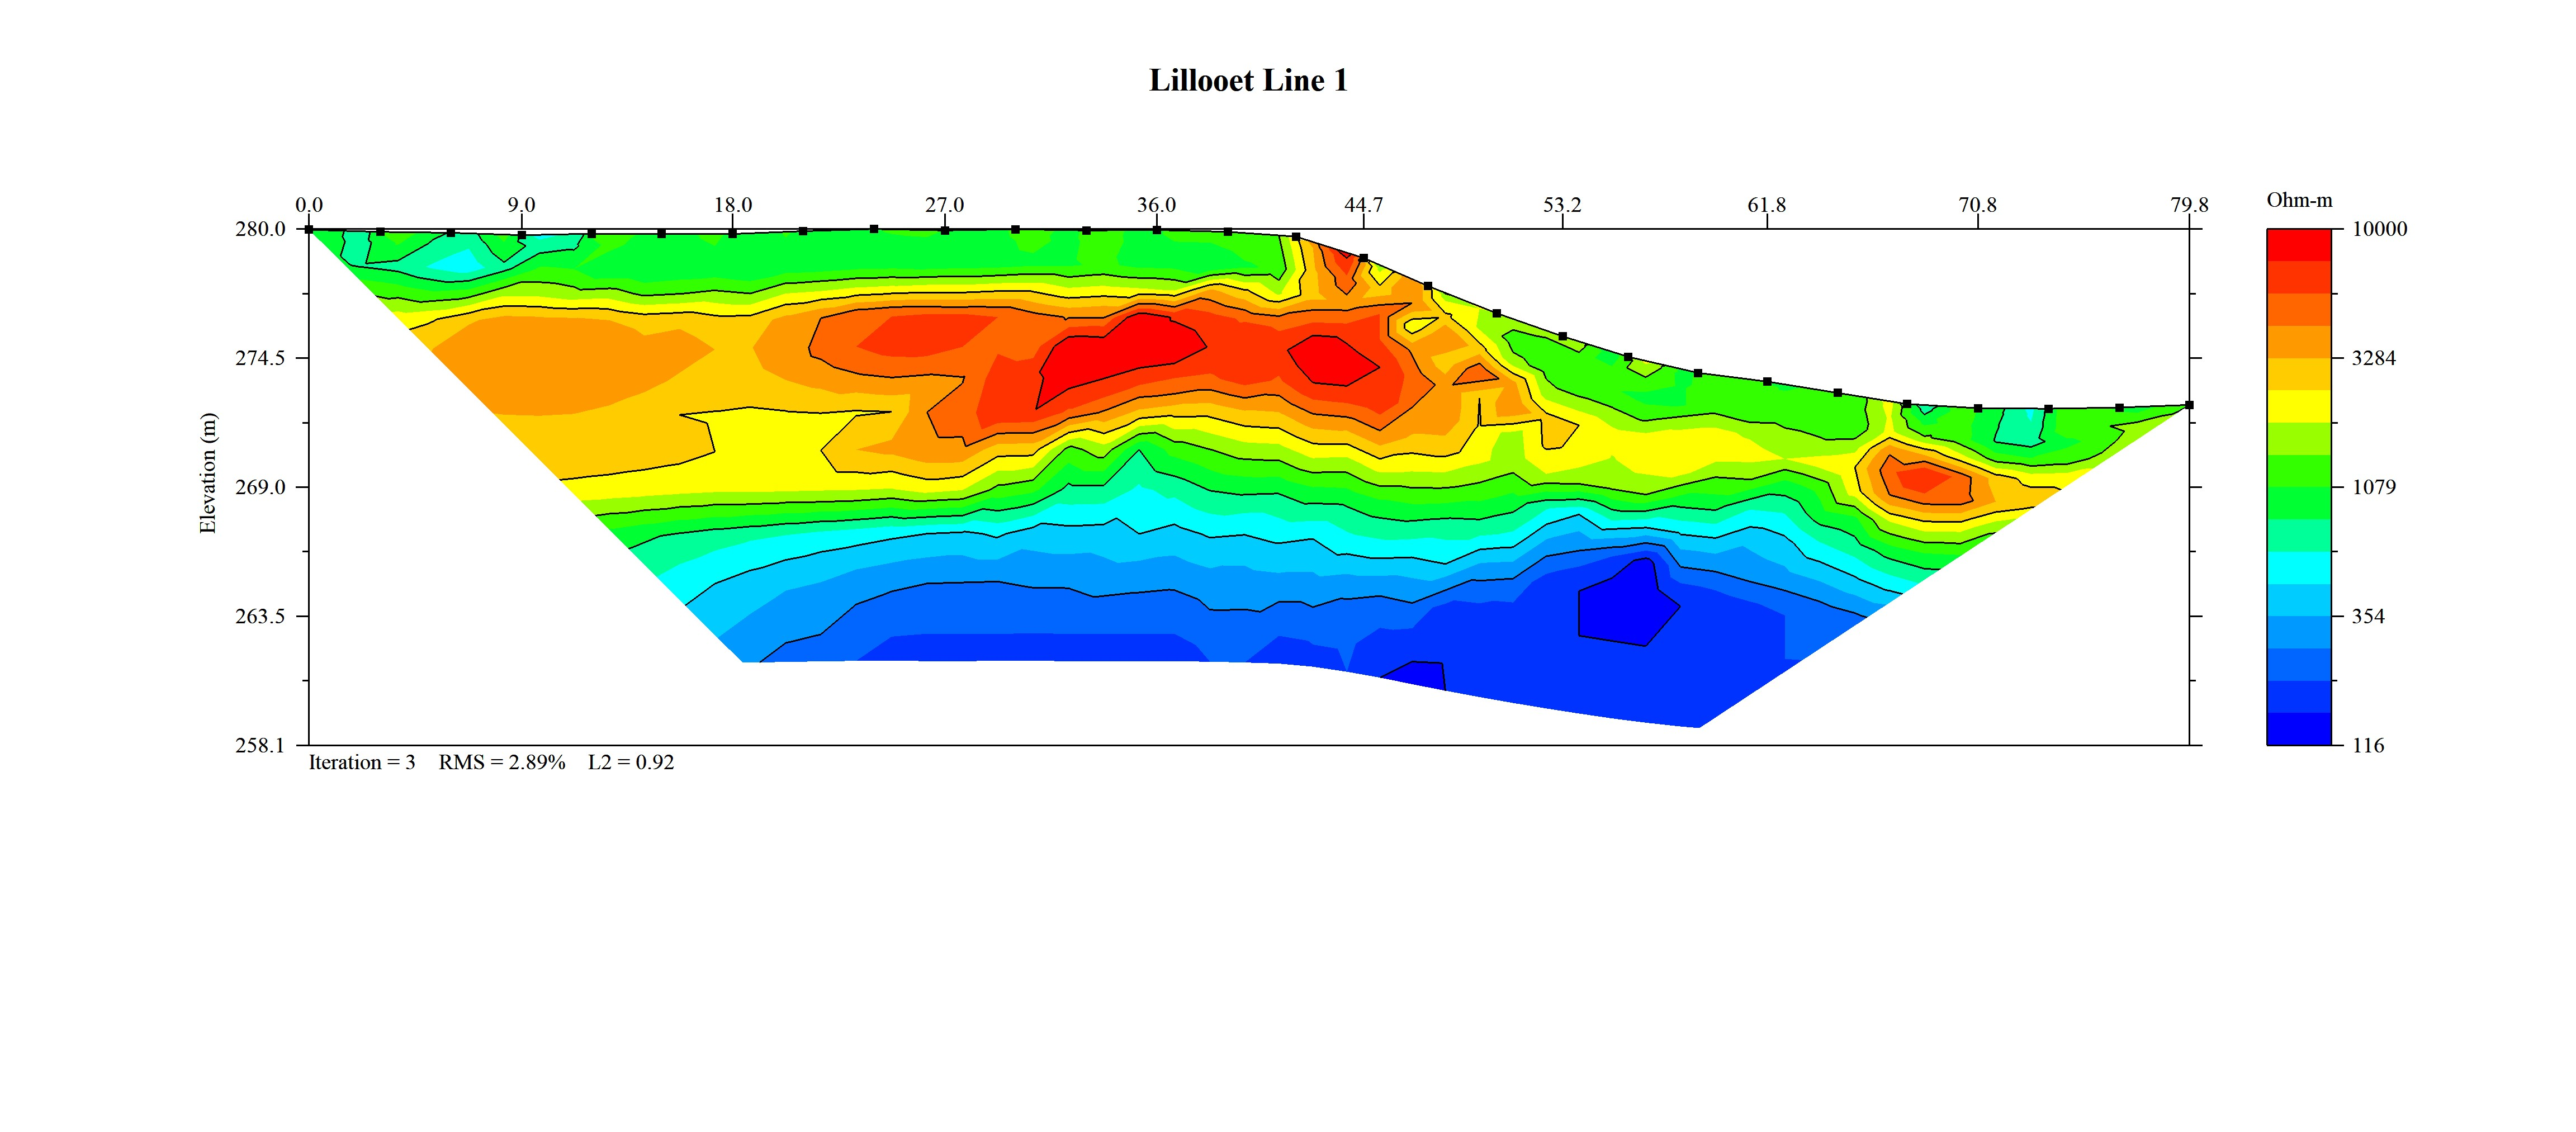

## Results 8: Using log resistivity, unfaulted vs. faulted
Unfaulted

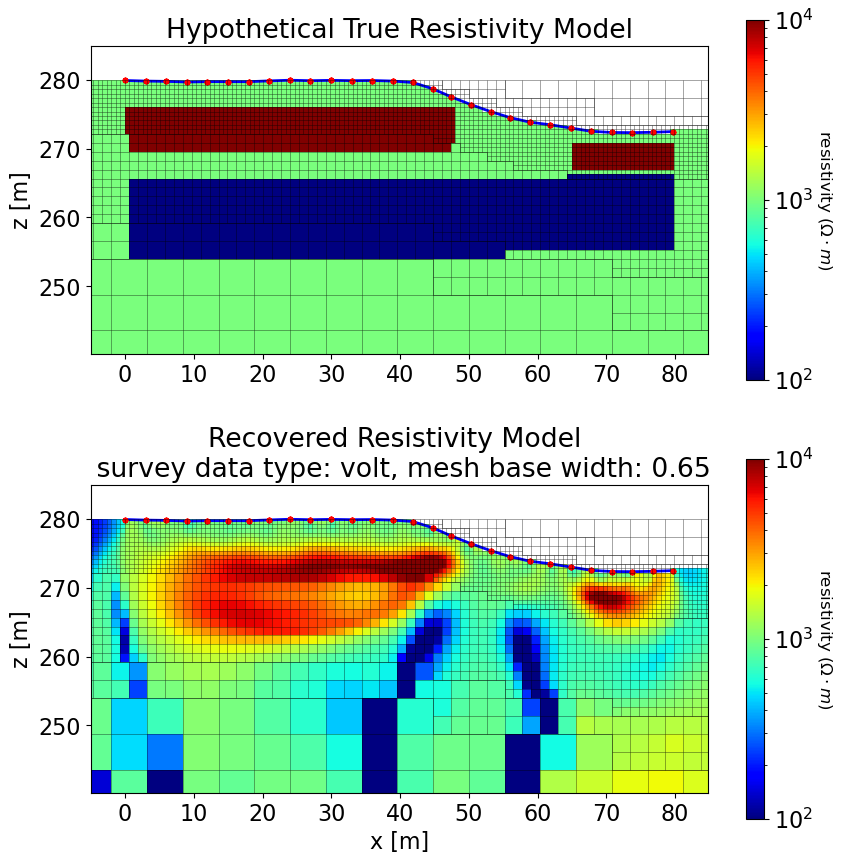

Faulted

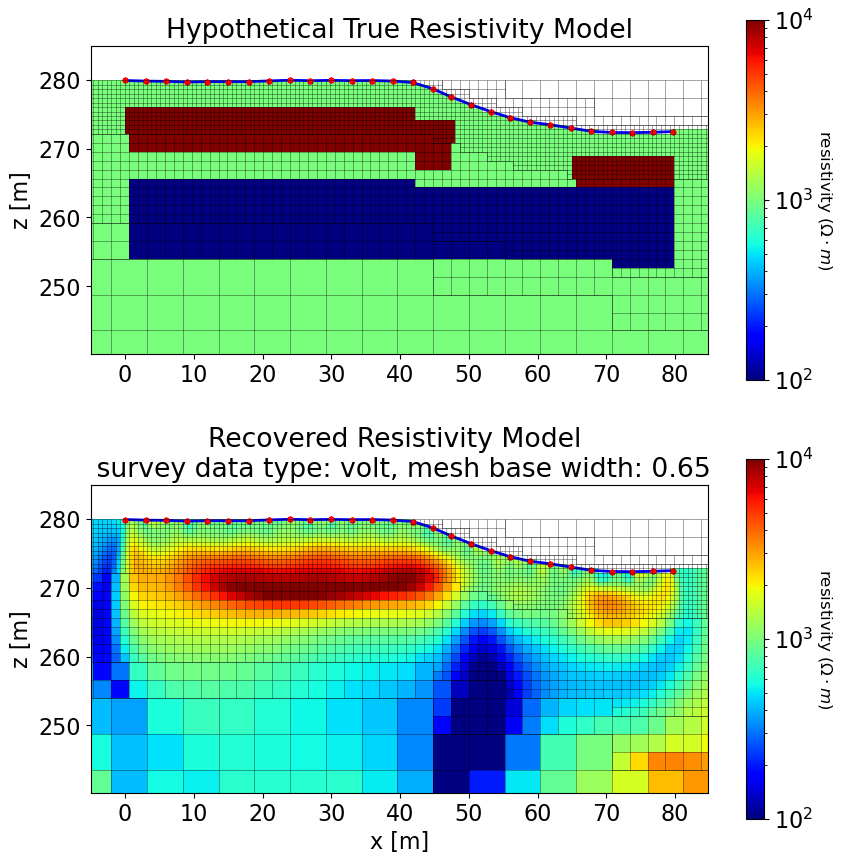

In [22]:
dpred_recovered = simulation_res.dpred(recovered_resistivity_model)
apparent_resistivities_recovered = apparent_resistivity_from_voltage(survey, dpred_recovered)

c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


## Results 7: Starting model: sand, reference model: sand, data inverted: simulations
Survey object data_type = volts

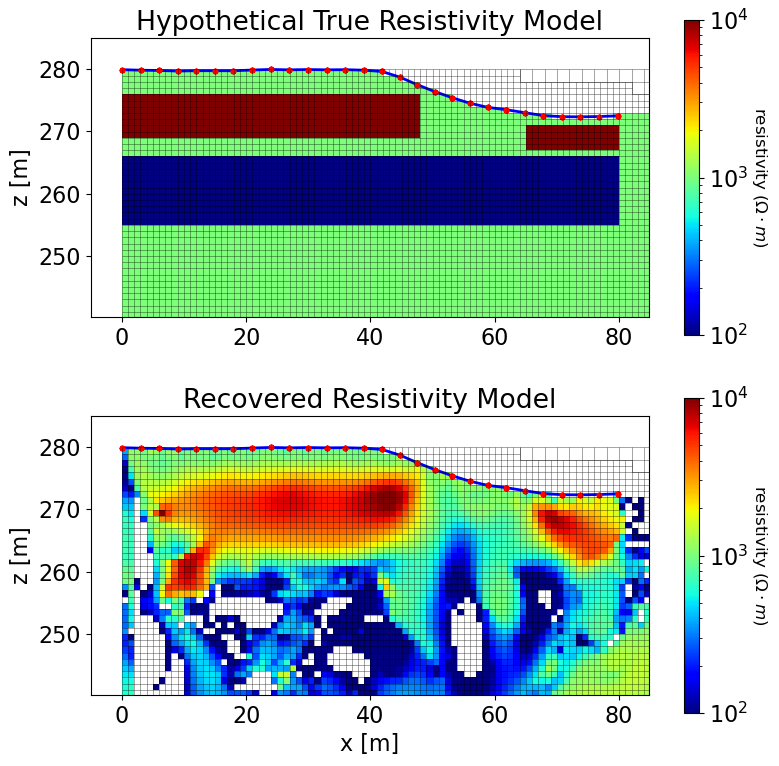